### Bulding a surrogate model

The goal is to build a model to predict activity from protein sequences \
The architecture is as follows

![](../../Data/figs/surrogate.png)

The sequences are fed to ESM2 (650M) to get the embeddings and then fed into a ML model (Linear/Ensemble/Neural Net) to get the final activity

In [4]:
import sys
sys.path.append('..')

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

import torch
import esm

In [6]:
from utils import helper

#### ESM2 wrapper class and function to get embeddings

In [7]:
class ESM2():
    def __init__(self, model_path, device='cpu') -> None:
        # self.model, self.alphabet = esm.pretrained.load_model_and_alphabet(model_path)
        self.model, self.alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        self.batch_converter = self.alphabet.get_batch_converter()
        self.model.eval()
        self.device = device

        if self.device == 'gpu':
            self.model.cuda()

        self.tok_to_idx = self.alphabet.tok_to_idx
        self.idx_to_tok = {v:k for k,v in self.tok_to_idx.items()}

    def get_res(self, sequence):
        data = [
            ("protein1", sequence)
        ]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

        if self.device == 'gpu':
            batch_tokens = batch_tokens.cuda()

        with torch.no_grad():
            results = self.model(batch_tokens, repr_layers=[33], return_contacts=True)

        return results

    def get_logits(self, sequence):

        results = self.get_res(sequence)
        return results['logits']

    def get_prob(self, sequence):
        logits = self.get_logits(sequence)
        prob = torch.nn.functional.softmax(logits, dim=-1)[0, 1:-1, :] # 1st and last are start and end tokens

        return prob.cpu().numpy()

In [8]:
esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt')

In [9]:
def get_embeddings_seq(sequences):
    embeddings = []
    for seq in tqdm(sequences):
        rep = esm2.get_res(sequence=seq)
        embeddings.append(rep['representations'][33].mean(1).numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings

Data Loading and Get Embeddings

In [10]:
root = '../..'
data_path = os.path.join(root, 'Data')

In [11]:
fasta_file = os.path.join(data_path, 'sequences_425.fasta')
meta_file = os.path.join(data_path, 'sequences_425.metadata.json')

In [12]:
## load fasta file and Metadata
records = helper.read_fasta(fasta_file)
seq_425_sequences = {}
for rec in records:
    seq_425_sequences[rec.id] = str(rec.seq)
    
with open(meta_file) as f:
    seq_425_meta = json.load(f)
seq_425_meta = pd.DataFrame(seq_425_meta).T

In [13]:
df = pd.concat([pd.DataFrame.from_dict(seq_425_sequences, orient='index', columns=['sequence']), seq_425_meta], axis=1)

In [14]:
embeddings = get_embeddings_seq(df['sequence'])

100%|██████████| 128/128 [04:01<00:00,  1.89s/it]


In [15]:
df['embeddings'] = list(embeddings)

In [16]:
df.head()

,sequence,esm2_650M_perplexity,activity,embeddings
seq_0_L_425,ATAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPIMQVK...,3.489924,10.552655,"[-0.02621314, -0.08718042, -0.08317378, 0.1298..."
seq_1_L_425,ATAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPIMQVK...,3.568502,9.338325,"[-0.027964618, -0.086735666, -0.08568832, 0.12..."
seq_2_L_425,ATAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPIMQVK...,3.499378,8.289414,"[-0.02771596, -0.088174716, -0.08482945, 0.130..."
seq_3_L_425,ATAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPIMQVK...,3.596867,7.007689,"[-0.022297397, -0.09509543, -0.083283156, 0.12..."
seq_4_L_425,ATAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPIMQVK...,3.550846,6.898567,"[-0.028365752, -0.087006845, -0.085807584, 0.1..."


In [17]:
embeddings.shape

(128, 1280)

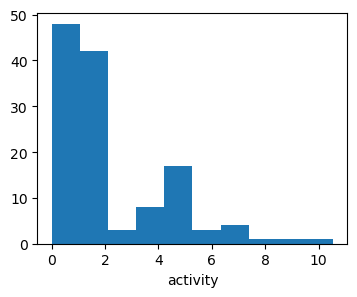

In [18]:
plt.figure(figsize=(4,3))
_ = plt.hist(df['activity'])
_ = plt.xlabel('activity')
plt.show()

We can see that the activity distribution is skewed. 

#### Data Set Splitting for Evaluvation

We will be trying out Ridge (linear) and Random Forest (Ensemble based) models on top of ESM2 embeddings. \
Since the activity values are skewed and most of the mass in under 0-2, to make a fair evaluvation, I decided to split the data in a stratified manner such that the test and train datasets will have a similar distribution

In [88]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer

from scipy.stats import uniform
from scipy.stats import spearmanr

In [89]:
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform') ## binning for stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [90]:
y = df['activity'].to_numpy().reshape(-1,1)
X = embeddings.copy()
y_binned = binner.fit_transform(y)

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


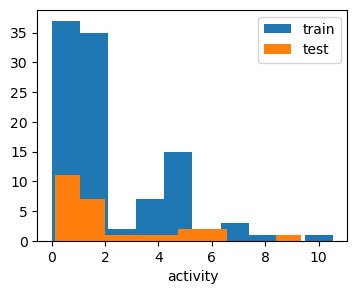

In [91]:
for train_index, test_index in skf.split(X, y_binned):
    break

X_train = X[train_index]
y_train = y[train_index]
y_binned_train = y_binned[train_index]

X_test = X[test_index]
y_test = y[test_index]
y_binned_test = y_binned[test_index]

fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.hist(y_train, label='train')
ax.hist(y_test, label='test')
ax.legend()
ax.set_xlabel('activity')
plt.show()

We can the the activity distribution of the train vs test set. Both sets have similar distribution

In [92]:
print(f'train set size: {train_index.shape[0]}')
print(f'test set size: {test_index.shape[0]}')

train set size: 102
test set size: 26


We want to do hyper parameter tuning - so we decided to split the **training set** into 5 folds for cross validation \
Below you can see the train and val splits for each of the 5 folds

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


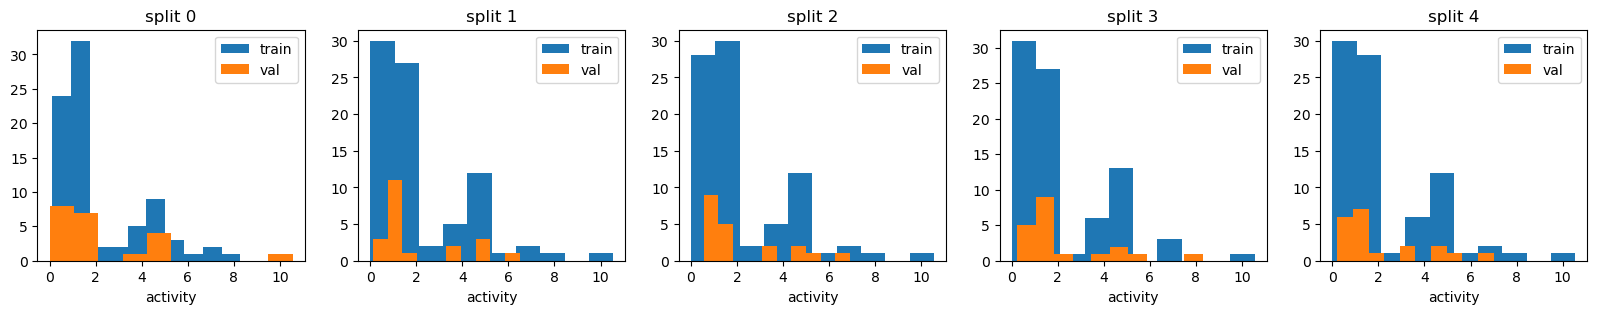

In [93]:
fig, ax = plt.subplots(1, 5, figsize=(20,3))
for i, (train_index, val_index) in enumerate(skf.split(X_train, y_binned_train)):
    ax[i].set_title(f'split {i}')
    ax[i].hist(y_train[train_index], label='train')
    ax[i].hist(y_train[val_index], label='val')
    ax[i].legend()
    ax[i].set_xlabel('activity')
plt.show()

#### Ridge Regression

Hyperparameter tuning and evaluvating on the test set

In [94]:
param_space = {
    'alpha': uniform(loc=0, scale=10),
}
ridge = Ridge(random_state=0)
clf = RandomizedSearchCV(ridge, param_space, n_iter=100, cv=skf.split(X_train, y_binned_train), scoring='r2', random_state=0)

In [95]:
search = clf.fit(X_train, y_train)

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


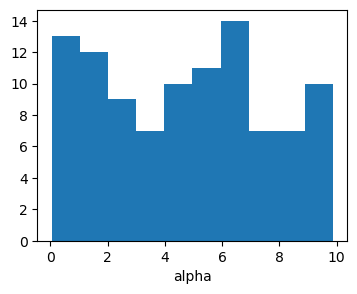

In [96]:
plt.figure(figsize=(4,3))
plt.hist([i['alpha'] for i in search.cv_results_['params']])
plt.xlabel('alpha')
plt.show()

In [97]:
alpha = search.best_params_['alpha']

In [98]:
alpha

0.046954761925470656

In [99]:
ridge = Ridge(alpha=alpha, random_state=0)
ridge.fit(X_train, y_train)
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

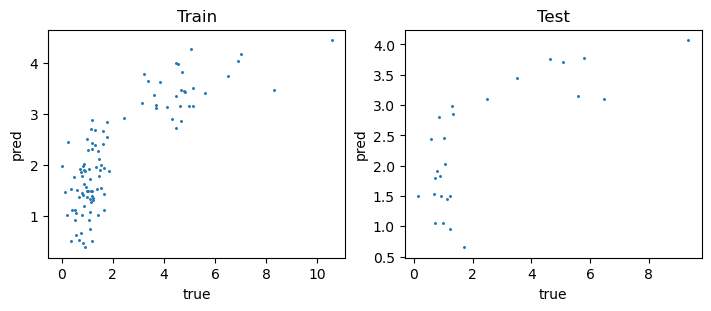

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), layout='constrained')

ax[0].scatter(y_train, y_pred_train, marker='.', s=5)
ax[1].scatter(y_test, y_pred_test, marker='.', s=5)

ax[0].set_xlabel('true')
ax[1].set_xlabel('true')
ax[0].set_ylabel('pred')
ax[1].set_ylabel('pred')
ax[0].set_title('Train')
ax[1].set_title('Test')

plt.show()

Not able to do a good job. Probably because we need something that can capture non-linear relationships

#### Random Forest

Hyperparameter tuning and evaluvating on test

In [101]:
param_space = {
    'n_estimators': np.linspace(100, 1000, 19, dtype=int),
    'max_depth': np.linspace(10, 100, 10, dtype=int),
    'min_samples_leaf': np.concatenate([np.array([1], dtype=int), np.linspace(2, 20, 10, dtype=int)]),
    'min_samples_split': np.linspace(2, 20, 10, dtype=int),
    'max_features': np.linspace(0.1, 1.0, 10),
    'max_leaf_nodes': [10, 50, 100]
}
rf_regressor = RandomForestRegressor(random_state=0)
clf = RandomizedSearchCV(rf_regressor, param_space, n_iter=100, n_jobs=8, cv=skf.split(X_train, y_binned_train), random_state=0)

In [102]:
search = clf.fit(X_train, y_train.flatten())

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [103]:
search.best_params_

{'n_estimators': 700,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 10,
 'max_features': 0.2,
 'max_depth': 100}

In [104]:
rf_params = {'n_estimators': 700,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 10,
 'max_features': 0.2,
 'max_depth': 100}

I am also building a RF with default params - just to see if hyperparammter tuing had any effect

In [105]:
rf_regressor = RandomForestRegressor(random_state=0, **rf_params)
rf_regressor_default = RandomForestRegressor(random_state=0)

rf_regressor.fit(X_train, y_train.flatten())
rf_regressor_default.fit(X_train, y_train.flatten())

y_pred_train = rf_regressor.predict(X_train)
y_pred_test = rf_regressor.predict(X_test)

y_pred_train_default = rf_regressor_default.predict(X_train)
y_pred_test_default = rf_regressor_default.predict(X_test)

Text(0, 0.5, 'pred')

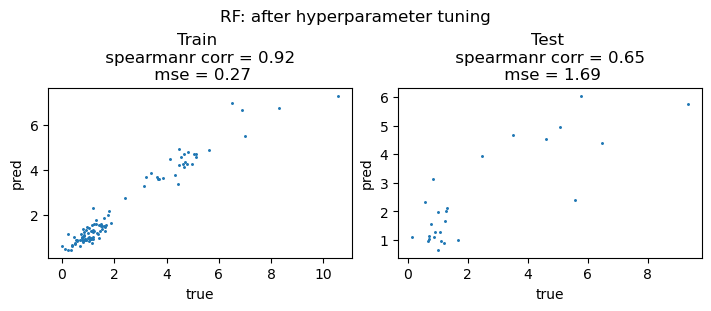

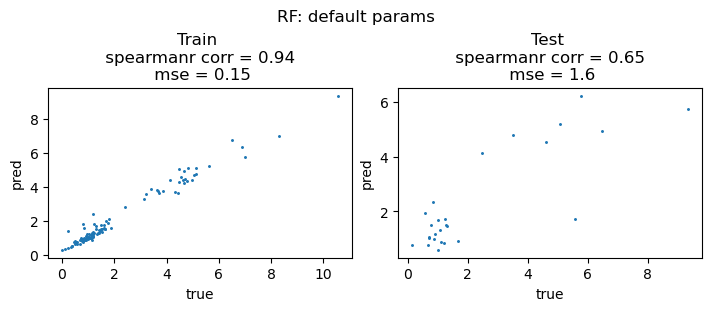

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), layout='constrained')

fig.suptitle('RF: after hyperparameter tuning')
ax[0].scatter(y_train, y_pred_train, marker='.', s=5)
ax[0].set_title(f'Train \n spearmanr corr = {round(spearmanr(y_train.flatten(), y_pred_train).statistic, 2)} \n mse = {round(mean_squared_error(y_train.flatten(), y_pred_train), 2)}')
ax[1].scatter(y_test, y_pred_test, marker='.', s=5)
ax[1].set_title(f'Test \n spearmanr corr = {round(spearmanr(y_test.flatten(), y_pred_test).statistic, 2)} \n mse = {round(mean_squared_error(y_test.flatten(), y_pred_test), 2)}')
ax[0].set_xlabel('true')
ax[1].set_xlabel('true')
ax[0].set_ylabel('pred')
ax[1].set_ylabel('pred')

fig, ax = plt.subplots(1, 2, figsize=(7,3), layout='constrained')

fig.suptitle('RF: default params')
ax[0].scatter(y_train, y_pred_train_default, marker='.', s=5)
ax[0].set_title(f'Train \n spearmanr corr = {round(spearmanr(y_train.flatten(), y_pred_train_default).statistic, 2)} \n mse = {round(mean_squared_error(y_train.flatten(), y_pred_train_default), 2)}')
ax[1].scatter(y_test, y_pred_test_default, marker='.', s=5)
ax[1].set_title(f'Test \n spearmanr corr = {round(spearmanr(y_test.flatten(), y_pred_test_default).statistic, 2)} \n mse = {round(mean_squared_error(y_test.flatten(), y_pred_test_default), 2)}')
ax[0].set_xlabel('true')
ax[1].set_xlabel('true')
ax[0].set_ylabel('pred')
ax[1].set_ylabel('pred')

For me both results are more or less same. I would say that the hyperparam tuned one has lesser overfitting

#### Training the model on full data and predicting on generated sequences

In [108]:
rf_regressor = RandomForestRegressor(random_state=0, **rf_params)
rf_regressor.fit(X, y.flatten())

RandomForestRegressor(max_depth=100, max_features=0.2, max_leaf_nodes=10,
                      min_samples_leaf=2, min_samples_split=6, n_estimators=700,
                      random_state=0)

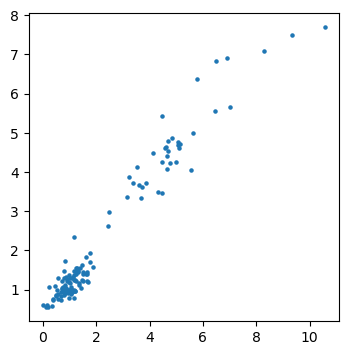

In [111]:
plt.figure(figsize=(4, 4))
plt.scatter(y.flatten(), rf_regressor.predict(X), s=5)

In [117]:
esm_records = helper.read_fasta(os.path.join(data_path, 'esm3_gen.fasta'))

In [118]:
esm_embeddings = get_embeddings_seq([str(rec.seq) for rec in esm_records])

100%|██████████| 200/200 [06:24<00:00,  1.92s/it]


In [120]:
pred_dict = {}
y_pred = rf_regressor.predict(esm_embeddings)
for rec, pred in zip(esm_records, y_pred):
    pred_dict[rec.id] = pred

Text(0.5, 0, 'pred activity')

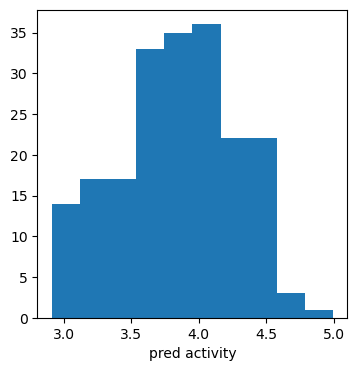

In [121]:
plt.figure(figsize=(4, 4))
plt.hist(y_pred)
plt.xlabel('pred activity')

In [122]:
# ## save to metadata
# meta_file = os.path.join(data_path, 'esm3_gen.metadata.json')
# for key in pred_dict:
#     helper.update_metadata_json(meta_file, key, 'p_activity', pred_dict[key])